# Modelling toolbox: stochastic simulations

*22nd September 2022* - **Credits:** Luca Ciandrini (luca.ciandrini@umontpellier.fr)

---

## aims
- Write a Monte Carlo simulation for the protein expression/degradation problem seen the previous lecture
- Develop an alternative simulation approach via the Gillespie algorithm (kinetic Monte Carlo)

We revise the equations that we ave analytically and numerically solved last week, and simulate different trajectories. At the end of the lecture you should be able to write a code to simulate a simple stochastic process (with two different methods), plot the trajectories and compare the results with the deterministic approach.

### 1-resources
- Check the resources associated to this lecture on the README file.

Before starting the tutorial, I will show you [this script](./Protein_partitioning.ipynb) for the stochastic protein partion problem we discussed last week - Theriot, J., Kondev, J., Garcia, H., Phillips, R. (2012). *Physical Biology of the Cell*. United Kingdom: CRC Press. Pages 43-48, available [here](https://www.google.fr/books/edition/Physical_Biology_of_the_Cell/t2SzDwAAQBAJ?hl=en&gbpv=1&printsec=frontcover)

# Tutorials

## Discrete stochastic

In [1]:
import matplotlib.pyplot as plt ## matplotlib is a module for plotting in python
import numpy as np

alpha = 1
mu = 0.1 
delta_t = 0.01

X = 0
t = 0

Xt = []
times = []
Xt.append(X)
times.append(t)

prob_prod = alpha*delta_t
prob_deg = X*mu*delta_t

t_max = 100

What are the 3 possible events in each time step? With which probability?

We are going to use the `random` library https://docs.python.org/3/library/random.html .

How would you try to simulate this situation? Think before looking down...



In [2]:
from random import random

while t < t_max :
    
    t += delta_t
    
    ran = random()
    
    prob_deg = X*mu*delta_t # Why do you have to compute that at each time step?
    
    if ran <= prob_prod:
        # production of 1 protein
        X = X + 1
    if ran > prob_prod and ran <= prob_prod + prob_deg :
        # degradation of 1 protein
        X = X - 1
        
    Xt.append(X)
    times.append(t)
    

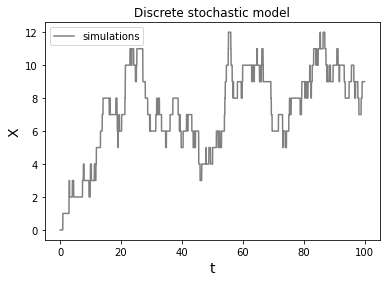

In [3]:
plt.plot(times,Xt, 'gray', label='simulations') 

#plt.ylim(0.,20.)
#plt.xlim(0.,t[-1])
plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend()
plt.show()

You can repeat the procedure and plot several *realisations*.

In [4]:
def sim_ge(a,m,delta,T):
    
    alpha = a
    mu = m 
    delta_t = delta

    X = 0
    t = 0.

    Xt = []
    times = []
    Xt.append(X)
    times.append(t)

    prob_prod = alpha*delta_t

    
    while t < T :
    
        t += delta_t
    
        ran = random()
    
        prob_deg = X*mu*delta_t # Why do you have to compute that at each time step?
    
        if ran <= prob_prod:
            # production of 1 protein
            X = X + 1
        if ran > prob_prod and ran <= prob_prod + prob_deg :
            # degradation of 1 protein
            X = X - 1
        
        Xt.append(X)
        times.append(t)
    
    return [times, Xt]

In [ ]:
outcome = sim_ge(1,0.1,0.01,100)

In [5]:
N_realisation = 10

t_realisation = []
X_realisation = []

delta_t = 0.01
for i in range(0,N_realisation):
    outcome = sim_ge(1,0.1,delta_t,100)
    
    t_realisation.append(outcome[0])
    X_realisation.append(outcome[1])
    #plt.plot(outcome[0],outcome[1], label=i) 

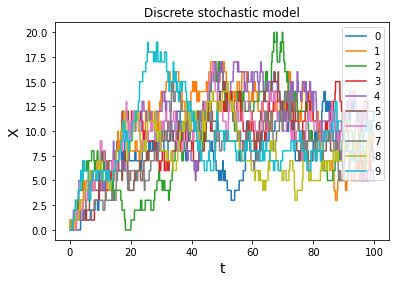

In [6]:
for i in range(0,N_realisation):
    plt.plot(t_realisation[i],X_realisation[i], label=i) 
    

plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend(loc=1)
plt.show()

What is the relation with the deterministic model?

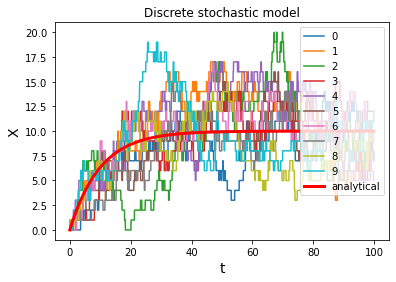

In [7]:
##### Plot the stochastic simulations 
for i in range(0,N_realisation):
    plt.plot(t_realisation[i],X_realisation[i], label=i) 
    


##### deterministic solution we found.
t = np.arange(0,100,.1) 

X = (alpha/mu)*(1.-np.exp(-mu*t))  
plt.plot(t,X, lw=3,color='red', label='analytical')

plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Discrete stochastic model')
plt.legend(loc=1)
plt.show()


- To be done: Compare mean value of trajectories with the analatycal solution.
- What about the steady state?

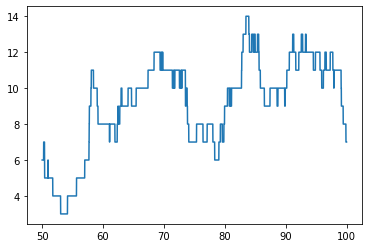

In [8]:
t_ss = int(50/delta_t)
plt.plot(t_realisation[0][t_ss:],X_realisation[0][t_ss:])

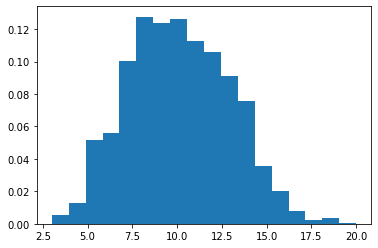

In [9]:
X_tot = []
for i in range(0,N_realisation): X_tot.extend(X_realisation[i][t_ss:])
plt.hist(X_tot, density=True, bins = max(X_tot)- min(X_tot)+1);

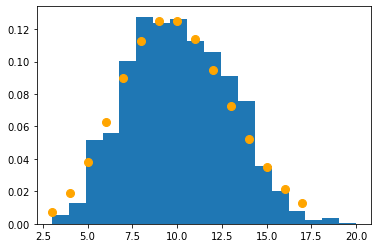

In [10]:
from scipy.stats import poisson

mean = alpha/mu

x = np.arange(poisson.ppf(0.01, mean),
              poisson.ppf(0.99, mean))
plt.plot(x, poisson.pmf(x, mean), 'o', ms=8, color='orange', label='poisson pmf')
plt.hist(X_tot, density=True, bins = max(X_tot)- min(X_tot)+1);

- What are the advantages of this method?
- What are the drawbacks?
---

## Kinetic Monte Carlo (Gillespie Algorithm)

The Gillespie algorithm is used to simulate trajectories of a system of stochastic equations for which the reaction rates are known. It is a discrete event simulation algorithm, but the $\Delta t$ varies.

There are two random numbers involved: one for the choice of the reaction (`r`), the other for the time interval (`dt`). The first is extracted from a uniform distribution, the second from an exponential (from [inverse sampling](https://stats.stackexchange.com/questions/508749/generating-random-samples-obeying-the-exponential-distribution-with-a-given-min) as done here or you could just use a python module).

In [11]:
# Step 1: Initialise
t_gil = 0
x_gil = 0

T_gil = []
X_gil = []
T_gil.append(t_gil)
X_gil.append(x_gil)

alpha = 1.
mu = 0.1 

In [12]:
# Step 2: define the propensities of all possible events
a = []
a.append(alpha) # production - reaction 0
a.append(mu*x_gil) # degradation - reaction 1
A = sum(a)
print(a, A)

[1.0, 0.0] 1.0


In [13]:
# Step 3: find the next time 
r1 = random()
dt = (1./A)*np.log(1./r1)
print(r1, dt)



0.6050099159728213 0.5025104310478897


In [14]:
# Step 4: pick the reaction
r2 = A*random()
if r2 < a[0]:
    x_gil += 1 # create a protein
else :
    x_gil -= 1 # destroy a protein

print(x_gil)


1


In [15]:
# Step 5: record simulation time and state
t_gil += dt
T_gil.append(t_gil)
X_gil.append(x_gil)

In [16]:
# Step 6: repeat until done

t_max = 100
while (t_gil<t_max):
    
    # Step 2: define the propensities of all possible events
    a[1] = mu*x_gil # degradation - reaction 1 (production does not change, no need to update)
    A = sum(a)
   
    
    # Step 3: find the next time 
    r1 = random()
    dt = (1./A)*np.log(1./r1)
    
    # Step 4: pick the reaction
    r2 = A*random()
    if r2 < a[0]:
        x_gil += 1 # create a protein
    else :
        x_gil -= 1 # destroy a protein
        
    # Step 5: record simulation time and state
    t_gil += dt
    T_gil.append(t_gil)
    X_gil.append(x_gil)
    

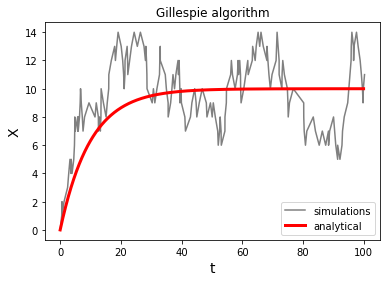

In [17]:
plt.plot(T_gil,X_gil, 'gray', label='simulations') 

#plt.ylim(0.,20.)
#plt.xlim(0.,t[-1])
plt.xlabel('t', fontsize = 14)
plt.ylabel('X', fontsize = 14)
plt.title('Gillespie algorithm')


##### deterministic solution we found.
t = np.arange(0,100,.1) 

X = (alpha/mu)*(1.-np.exp(-mu*t))  
plt.plot(t,X, lw=3,color='red', label='analytical')


plt.legend()
plt.show()